<a href="https://colab.research.google.com/github/viespil/Algebra/blob/master/TP1_ALC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geogr√°ficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcci√≥n de la red en NetworkX
import scipy


# Preambulo

En esta secci√≥n cargamos los datos y los visualizamos. Tambi√©n construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [ac√°](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). Tambi√©n descargamos los barrios de CABA como complemento para los gr√°ficos.

In [ ]:
# Leemos el archivo, retenemos aquellos museos que est√°n en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualizaci√≥n

<Axes: >

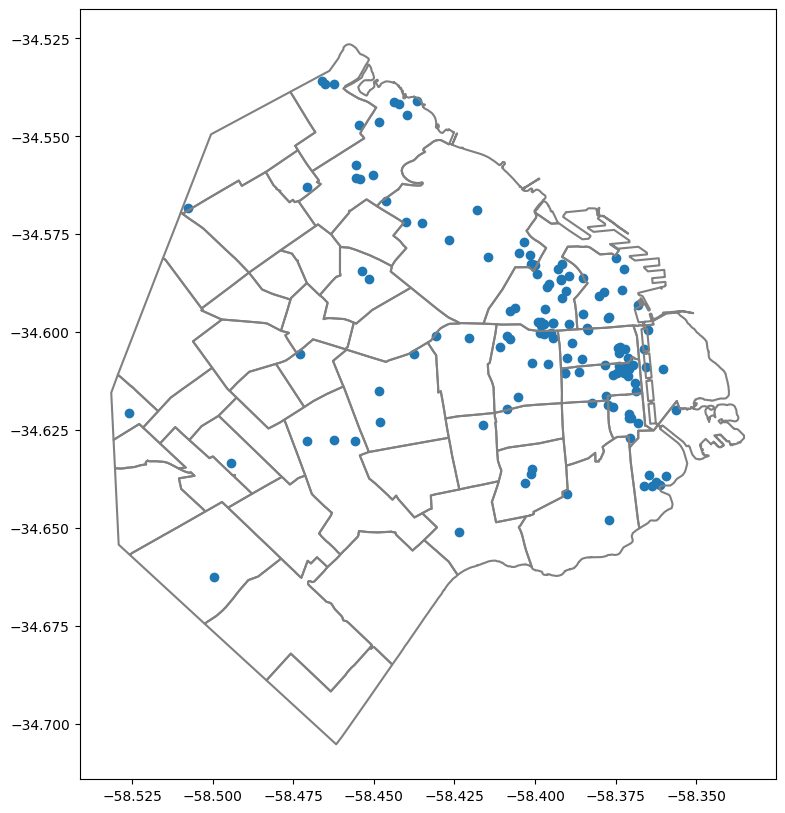

In [ ]:
# Armamos el gr√°fico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## C√°lculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el c√°lculo de distancias no es una operaci√≥n obvia. Una opci√≥n es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [ ]:
# En esta l√≠nea:
# Tomamos museos, lo convertimos al sistema de coordenadas de inter√©s, extraemos su geometr√≠a (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ m√°s cercanos

In [ ]:
def construye_adyacencia(D,m):
    # Funci√≥n que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores l√≥gicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que est√©n a una distancia menor o igual a la del m-esimo m√°s cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcci√≥n de la red en NetworkX (s√≥lo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geogr√°ficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

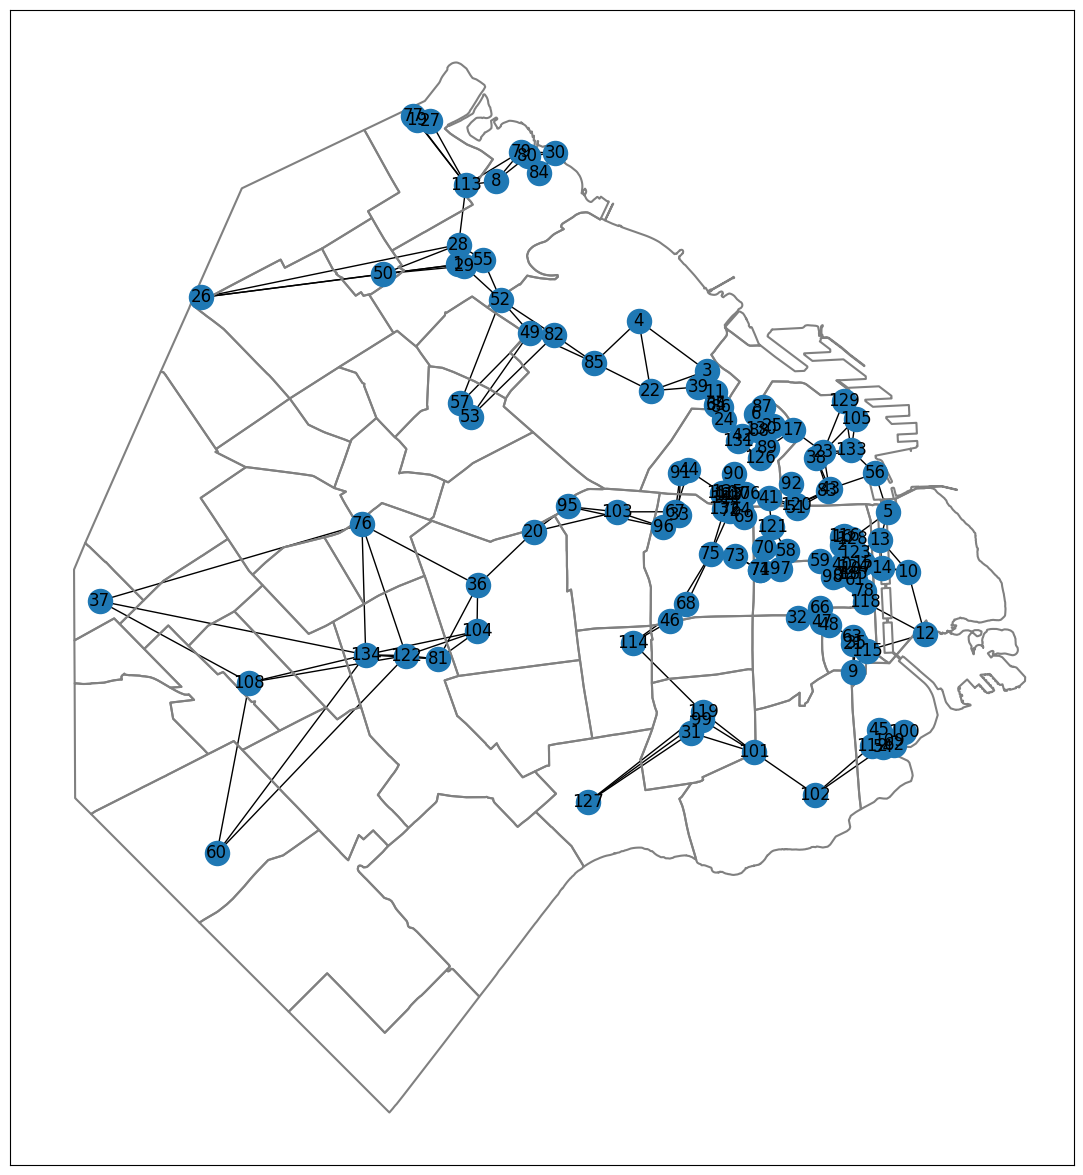

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualizaci√≥n de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resoluci√≥n del TP

Aqu√≠ empieza la aventura... ¬°diviertanse y consulten lo que necesiten!

## Punto 1:
Partimos de la ecuaci√≥n de PageRank:

$$
\mathbf{p} = (1 - \alpha) C \mathbf{p} + \frac{\alpha}{N} \mathbf{1}
$$

Pasamos todo a un lado:

$$
(I - (1 - \alpha)C)\mathbf{p} = \frac{\alpha}{N} \mathbf{1}
$$

Multiplicamos por $\frac{N}{\alpha}$ ambos lados

$$
\frac{N}{\alpha}(I - (1 - \alpha)C)\mathbf{p} = \mathbf{1}
$$

Entonces, si definimos:

$$
M = \frac{N}{\alpha}(I - (1 - \alpha)C), \quad \mathbf{b} = \mathbf{1}
$$

Obtenemos la ecuaci√≥n:

$$
M \mathbf{p} = \mathbf{b}
$$


## Punto 2:

Para que la ecuaci√≥n $ Mp = b $ tenga una √∫nica soluci√≥n, es necesario que $ M $ sea inversible.

Dado que $ M = \frac{N}{\alpha}(I - (1 - \alpha)C) $ y pedir que una matriz sea inversible es lo mismo que pedir que su determinante sea distinto de 0, pedir que el determinante de $M$ sea distinto de 0 es lo mismo que pedir que $ A = I - (1 - \alpha)C$ y $\frac{N}{\alpha}$ sean distintos de 0. N es la cantidad de museos no tendr√≠a sentido que fuera 0, entonces $\frac{N}{\alpha} > 0$. Por eso basta con probar que $ A = I - (1 - \alpha)C$ es inversible.

Para ello, antes vamos a demostrar una propiedad que nos ayudar√° m√°s adelante. $Mx = b$ tiene unica solucion $\Leftrightarrow$ el n√∫cleo de $M$ es 0:

$\Rightarrow$ En particular, el sistema homog√©neo $Mx = 0$ tambi√©n tiene una √∫nica soluci√≥n. Como siempre existe al menos la soluci√≥n $x = 0$, esto implica que esa es la √∫nica soluci√≥n.

$\Leftarrow$ Supongamos que existen dos soluciones $x_1$ y $x_2$ tales que:

$$
Mx_1 = b \quad \text{y} \quad Mx_2 = b
$$

Restando ambas ecuaciones obtenemos:

$$
M(x_1 - x_2) = 0 \Rightarrow x_1 - x_2 \in \ker(M)
$$

Pero por hip√≥tesis, $\ker (M) = \{0\}$. Entonces:

$$
x_1 - x_2 = 0 \Rightarrow x_1 = x_2
$$

Por lo tanto, la soluci√≥n es √∫nica.

Demostraci√≥n por el absurdo de que $ I - B $ es inversible si $ \|B\| < 1 $:

Supongamos que $ B \in \mathbb{R}^{n \times n} $ es una matriz cuadrada tal que $ \|B\|_1 < 1 $, pero que $ I - B $ no es invertible.

Entonces por la propiedad que demostramos anteriormente existe $ x \ne 0 $ tal que:

$
(I - B)x = 0 \Rightarrow x = Bx
$

Tomando norma 1 en ambos lados:

$
\|x\|_1 = \|Bx\|_1 \leq \|B\|_1\|x\|_1
\Rightarrow 1 \leq \|B\|_1
$

Esto contradice el supuesto de que $ \|B\|_1 < 1 $.

Por lo tanto, la suposici√≥n es falsa. Se concluye que:

$
\boxed{I - B \text{ es invertible si } \|B\|_1 < 1}
$

Recapitulando, queriamos ver que $ A = I - (1 - \alpha)C$ era inversible. Por lo visto anteriormente, basta con ver que $ \|(1 - \alpha)C\|_1 < 1 $,


Como $ C $ es estoc√°stica por columnas, se cumple $ \|C\|_1 = 1 $, y por lo tanto:

$
\|(1 - \alpha)C\|_1 = |(1 - \alpha)|\|C\|_1 = |1 - \alpha|
$

Basta con pedir que $|1 - \alpha| < 1$
$$
-1 < 1 - \alpha < 1
$$

$$
2 > \alpha > 0
$$

Vale ya que $ 0 < \alpha < 1 $

Entonces se puede aplicar el resultado: $ I - (1 - \alpha)C $ es invertible. Esto implica que $ M $ tambi√©n es invertible, y por lo tanto el sistema tiene soluci√≥n √∫nica.

Conclusi√≥n: para todo $ 0 < \alpha < 2 $, la matriz $ M $ es invertible y el sistema tiene soluci√≥n √∫nica.



## Punto 3:

In [ ]:
def matriz_Kinv(A):
    grados = np.sum(A, axis=1)
    inv_grados = np.where(grados != 0, 1.0 / grados, 0.0)
    return np.diag(inv_grados)

def calcula_matriz_C(A):
  return A.T @ matriz_Kinv(A)

def matriz_M(A, C, alpha):
  A = A.copy()
  N = A.shape[0]

  return (N/alpha) * (np.eye(N) - (1 - alpha) * C)

def calculaLU(matriz):
  # matriz es una matriz de NxN
  # Retorna la factorizaci√≥n LU a trav√©s de una lista con dos matrices L y U de NxN.
  matriz = matriz.copy()
  n = matriz.shape[0]
  L = np.eye(n)
  U = matriz.astype(float)
  for j in range(n):
      for i in range(j+1, n):
          L[i, j] = U[i, j] / U[j, j]
          U[i, j:] -= L[i, j] * U[j, j:]

  return [L, U]

def calcula_pagerank(A,alfa):
  # Funci√≥n para calcular PageRank usando LU
  # A: Matriz de adyacencia
  # d: coeficientes de damping
  # Retorna: Un vector p con los coeficientes de page rank de cada museo
  C = calcula_matriz_C(A)
  N = A.shape[0] # Obtenemos el n√∫mero de museos N a partir de la estructura de la matriz A
  M = matriz_M(A, C, alfa)
  L, U = calculaLU(M) # Calculamos descomposici√≥n LU a partir de C y d
  b = np.ones(N) # Vector de 1s, multiplicado por el coeficiente correspondiente usando d y N.
  Up = scipy.linalg.solve_triangular(L,b,lower=True) # Primera inversi√≥n usando L
  p = scipy.linalg.solve_triangular(U,Up) # Segunda inversi√≥n usando U
  return p

In [ ]:
def visualizar_red_pagerank(G, G_layout, pagerank, barrios):
    # Escalamos el tama√±o de los nodos proporcional al pagerank
    node_sizes = 1000 * pagerank / np.max(pagerank)

    fig, ax = plt.subplots(figsize=(8, 8))
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray', ax=ax)

    # Dibujamos el grafo con nodos coloreados y escalados
    nx.draw_networkx(
        G,
        pos=G_layout,
        ax=ax,
        node_size=node_sizes,
        node_color=pagerank,
        cmap='viridis',
        with_labels=False,
        edge_color='lightgray',
        alpha=0.8
    )

    # Colorbar vinculada expl√≠citamente al eje
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(pagerank), vmax=max(pagerank)))
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("PageRank")

    plt.title("Red de Museos con Tama√±os seg√∫n PageRank")
    plt.axis("off")
    plt.show()


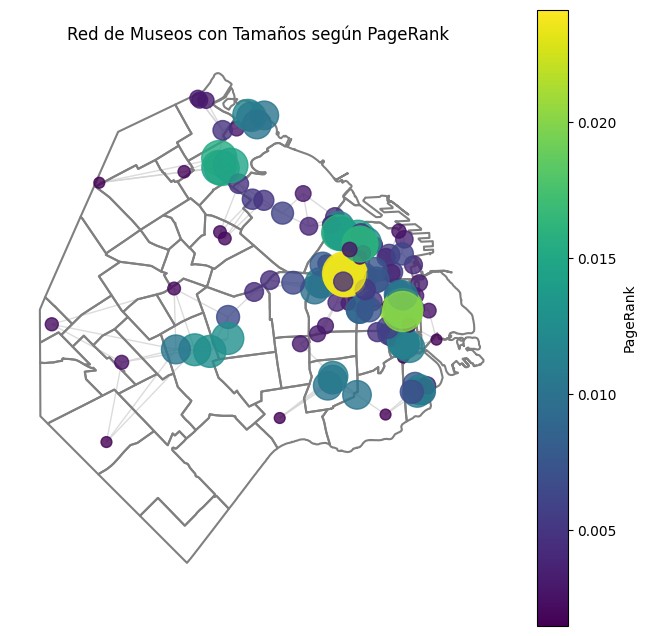

In [ ]:
# Punto A
alpha = 1/5
p = calcula_pagerank(A, alpha)
visualizar_red_pagerank(G, G_layout, p, barrios)

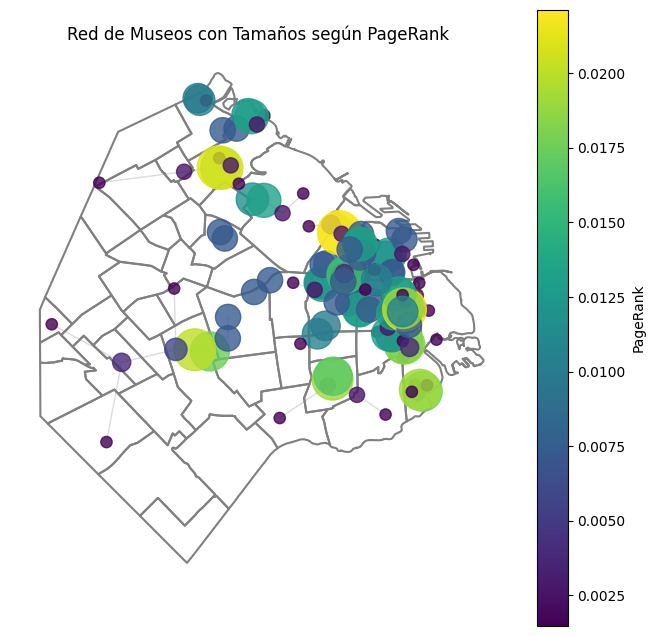

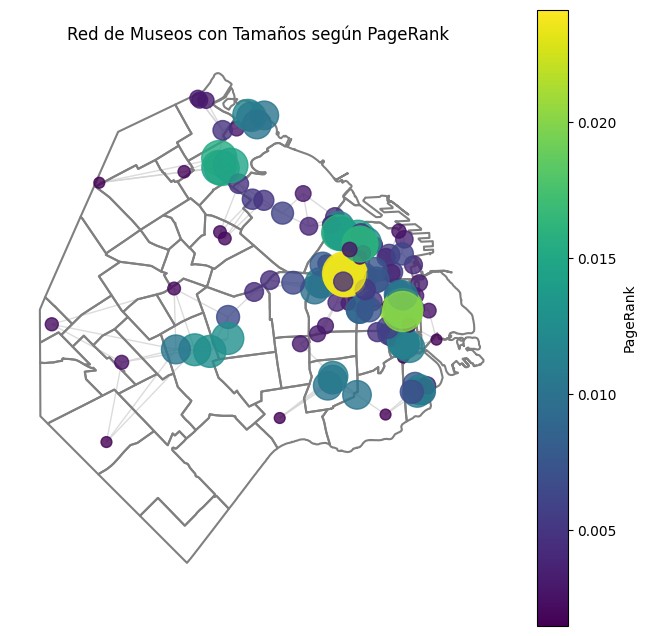

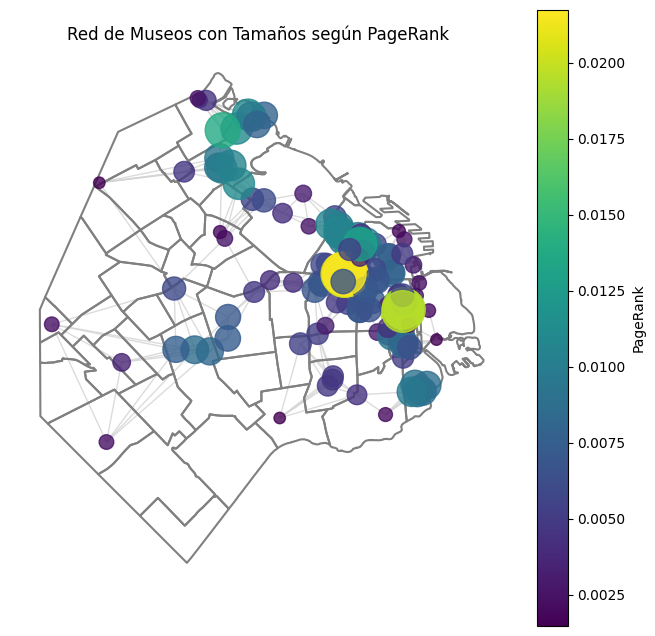

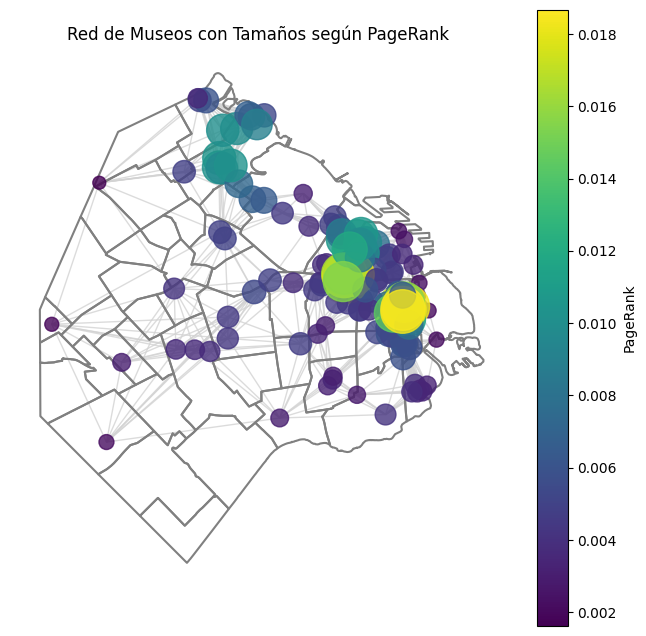

In [ ]:
# Punto B
m_vals = [1, 3, 5, 10] # Cantidad de links por nodo
pageranks_por_m = []
for m_i in m_vals:
  A_i = construye_adyacencia(D, m_i)
  G_i = nx.from_numpy_array(A_i)
  p_i = calcula_pagerank(A_i, 1/5)
  visualizar_red_pagerank(G_i, G_layout, p_i, barrios)
  pageranks_por_m.append(p_i)


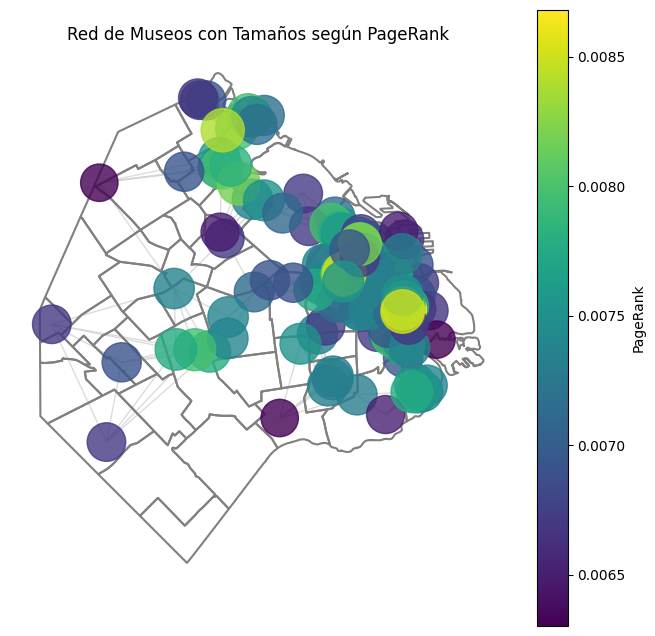

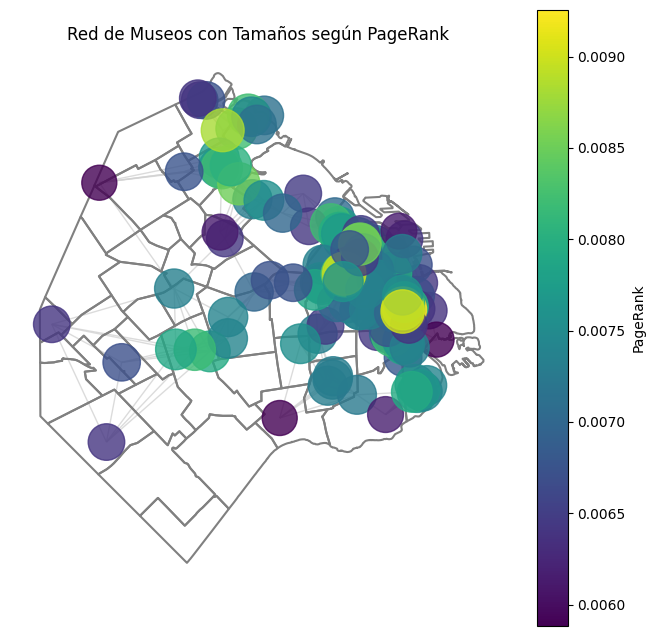

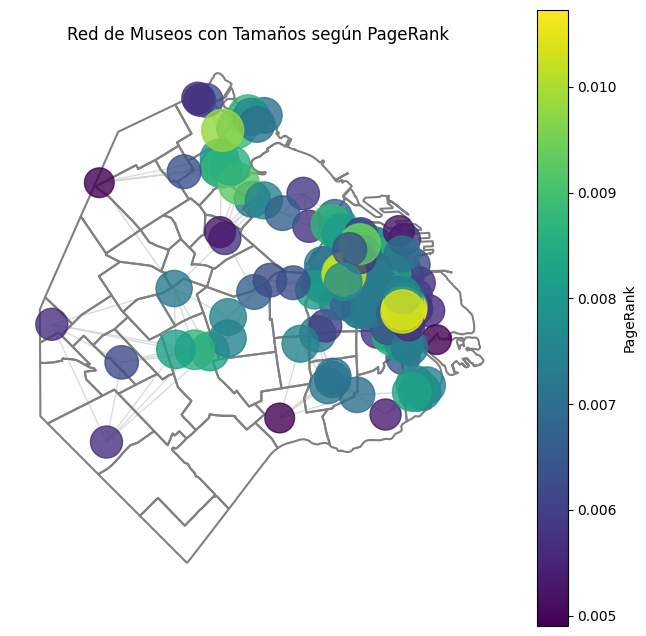

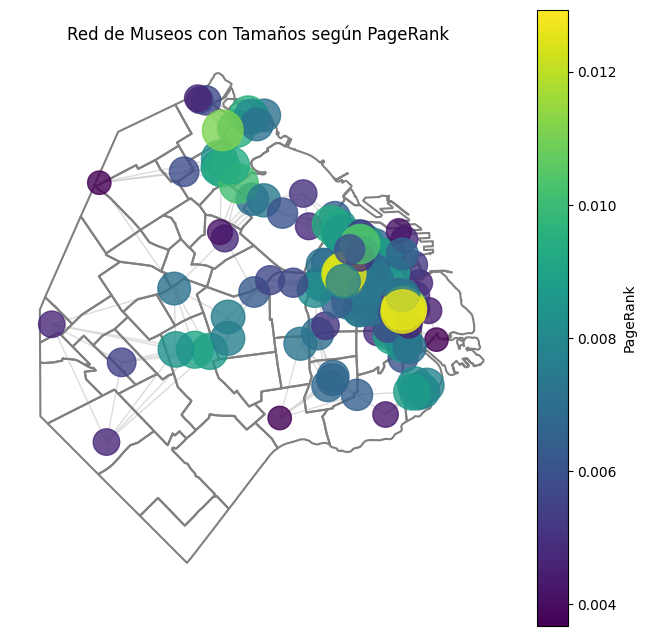

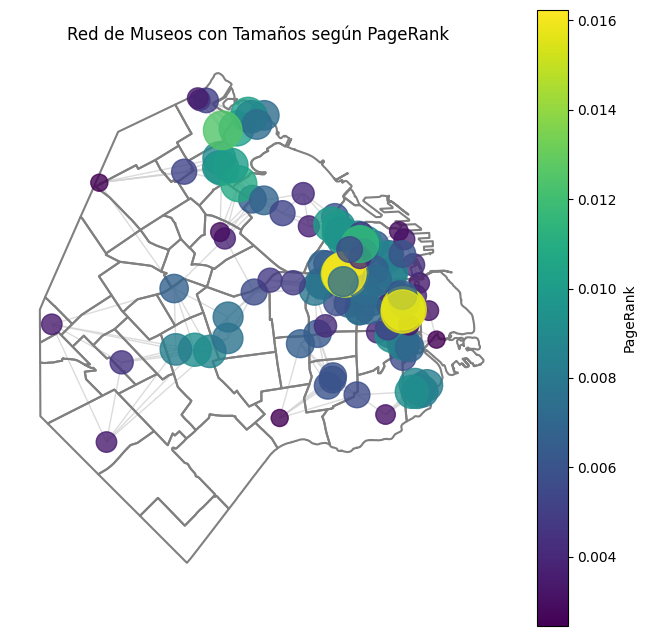

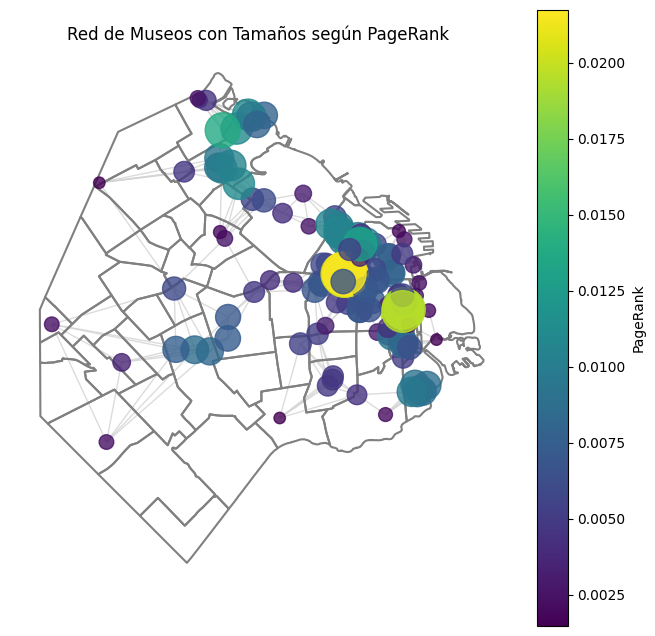

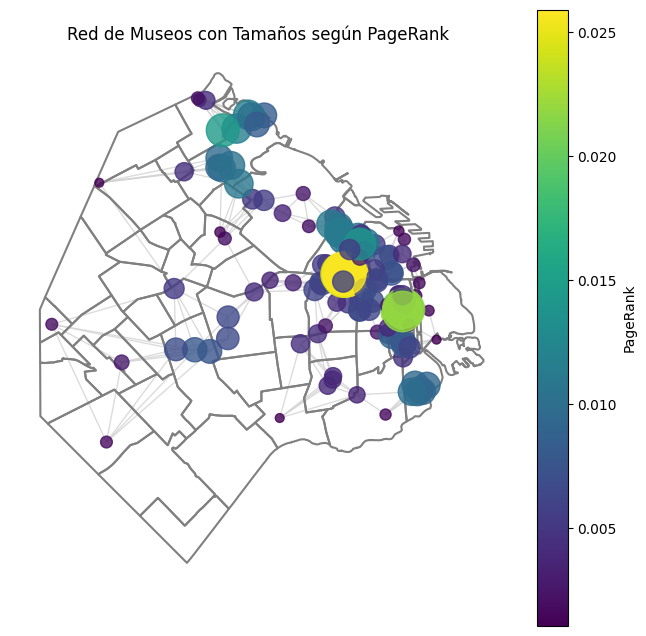

In [ ]:
# Punto C
alpha_vals = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
pageranks_por_alpha = []

for alpha_i in alpha_vals:
  A_i = construye_adyacencia(D, 5)
  G_i = nx.from_numpy_array(A_i)
  p_i = calcula_pagerank(A_i, alpha_i)
  visualizar_red_pagerank(G_i, G_layout, p_i, barrios)
  pageranks_por_alpha.append(p_i)

In [ ]:
def graficar_pageranks_por_param(pagerank_list, param_values, museums, param_name, constant):
  top_indexes = []

  for i, p in enumerate(pagerank_list):
    param_val = param_values[i]
    top_indexes += np.argsort(p)[-3:][::-1].tolist()

  top_indexes = np.unique(top_indexes)
  museums_rank_variation = np.array(pagerank_list).T
  names = museums.iloc[:]['name'].values

  plt.figure(figsize=(15, 6))

  for i in top_indexes:
    plt.plot(param_values, museums_rank_variation[i], label=names[i])

  plt.title(f"Museos que llegaron al top 3 para alg√∫n {param_name} con {constant}")
  plt.xlabel(f"Valor de {param_name}")
  plt.ylabel("Ranking")
  plt.legend()
  plt.grid(True)

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.tight_layout()
  plt.show()

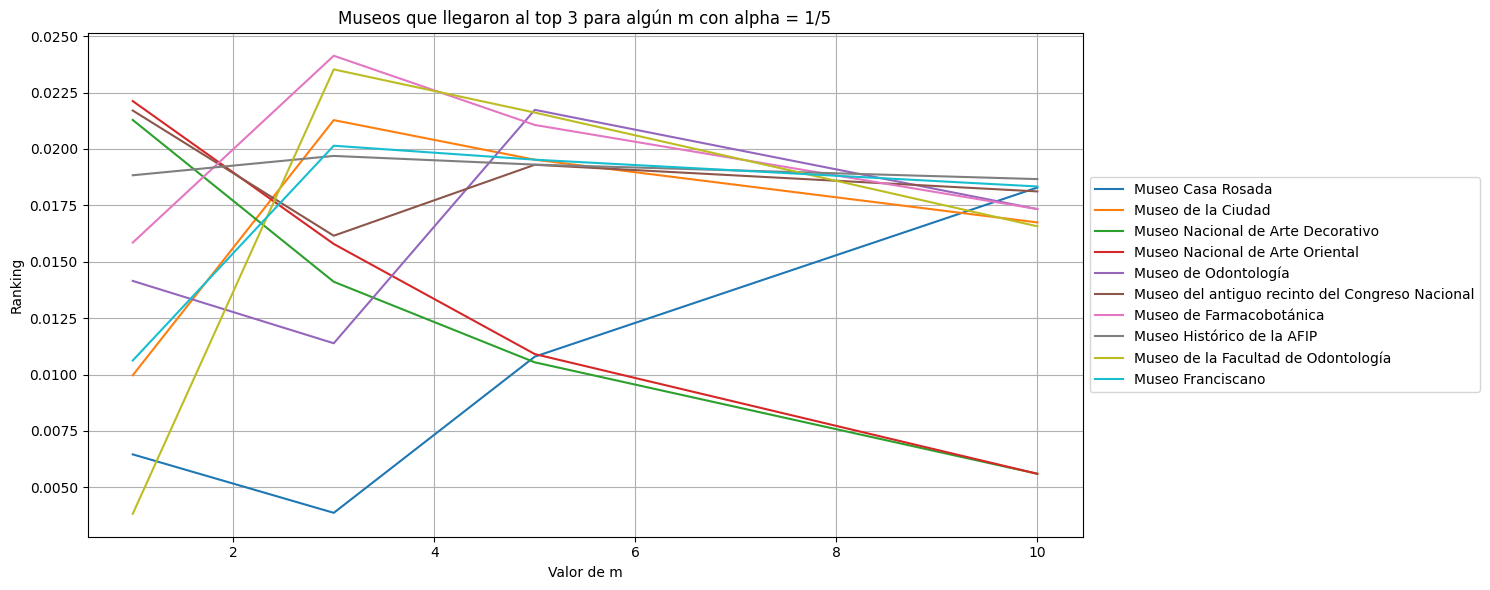

In [ ]:
graficar_pageranks_por_param(pageranks_por_m, m_vals, museos, 'm', 'alpha = 1/5')

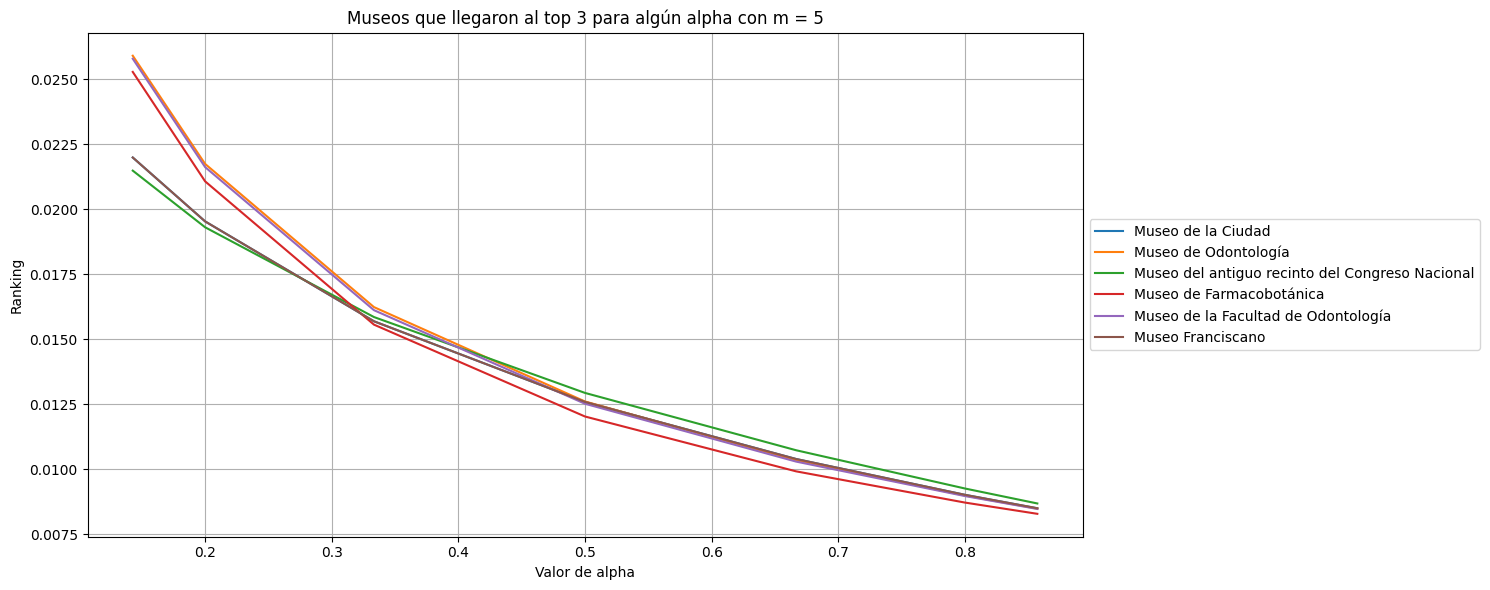

In [ ]:
graficar_pageranks_por_param(pageranks_por_alpha, alpha_vals, museos, 'alpha', 'm = 5')

## Punto 3.a y 3.b

### Variaci√≥n del par√°metro $ \alpha $

Se observa un comportamiento estable en los rankings al variar $ \alpha $: los museos que entran al top 3 tienden a mantenerse en √©l para m√∫ltiples valores de $ \alpha $, aunque sus posiciones relativas cambien ligeramente. Esto sugiere que la estructura de la red, una vez fijada (con $ m = 5 $), determina con solidez cu√°les museos son m√°s centrales, independientemente del valor espec√≠fico de $ \alpha $.

Los museos m√°s destacables en este caso son:

- Museo de la Facultad de Odontolog√≠a
- Museo del antiguo recinto del Congreso Nacional
- Museo de Odontolog√≠a

Estos aparecen recurrentemente en el top 3, lo que indica que est√°n ubicados en zonas bien conectadas o estrat√©gicas de la red. A medida que $ \alpha $ decrece (es decir, hay menor probabilidad de salto aleatorio), las conexiones entre museos tienen mayor relevancia, y algunos museos como el Museo de la Facultad de Odontolog√≠a logran posicionarse a√∫n mejor. Una tendencia interesante que pudimos observar es el caso del Museo de Farmacobotanica y el Museo del antiguo recinto del Congreso Nacional. El primero comienza en un punto relativamente alto en el ranking, pero cae ultimo entre los museos observados para un $ \alpha $ mayor, mientras que para el segundo sucede exactamente lo contrario.

### Variaci√≥n del par√°metro $ m $

A diferencia del caso anterior, al variar $ m $ se observa m√°s inestabilidad en los rankings: hay mayor rotaci√≥n en los museos que llegan al top 3. Esto se debe a que modificar $ m $ altera directamente la red, agregando o eliminando conexiones, y por lo tanto cambia la estructura sobre la cual se calcula el PageRank.

Entre los museos que se destacan para alg√∫n valor de $ m $, encontramos:

- Museo Nacional de Arte Oriental, que aparece √∫nicamente para $ m = 1 $, lo que sugiere que es central en una red m√°s local o dispersa, pero pierde relevancia al incrementarse la conectividad.
- Museo Casa Rosada, que aparece √∫nicamente para $ m = 10 $, lo que muestra que redes m√°s densas permiten que museos m√°s perif√©ricos ganen relevancia.
- Otros museos como el Museo de la Facultad de Odontolog√≠a, Museo de Farmacobot√°nica y Museo del antiguo recinto del Congreso Nacional aparecen para m√∫ltiples valores de $ m $, lo cual indica que mantienen su relevancia tanto en redes m√°s locales como en redes densas.

### Comparaci√≥n general

La variaci√≥n en $ \alpha $ afecta principalmente la suavidad del ranking, pero no altera dr√°sticamente qui√©nes son los museos m√°s importantes.

En cambio, la variaci√≥n en $ m $ transforma la red misma, haciendo que el conjunto de museos relevantes cambie notablemente.

Por lo tanto, podemos concluir que el par√°metro $ m $ tiene un impacto estructural en la red y en la definici√≥n de centralidad, mientras que $ \alpha $ modula c√≥mo se interpreta esa estructura en t√©rminos del comportamiento del navegante aleatorio.



## Punto 4:

El vector $w$ cuenta todas las visitas recibidas por cada museo. Para una persona que entra por un museo dado, las visitas que genera se distribuyen seg√∫n:

- En el paso $k=0$: La distribuci√≥n es $C^0 v = I v = v$, es decir, los visitantes est√°n en sus museos de entrada.
- En el paso $k=1$: La distribuci√≥n es $C^1 v$, los visitantes se han movido una vez seg√∫n $C$.
- En el paso $k=2$: La distribuci√≥n es $C^2 v$, los visitantes se han movido una segunda vez seg√∫n $C$, y asi sucesivamente.
- Hasta el paso $k=r-1$: La distribuci√≥n es $C^{r-1} v$.

El n√∫mero total de visitas a cada museo es la suma de las personas presentes en cada paso, desde $ k=0 $ hasta $ k=r‚àí1 $. Dado que cada persona realiza $r$ visitas, el vector $w$ se puede expresar como:

$$
w = C^0 v + C^1 v + C^2 v +‚ãØ+ C^{r‚àí1} v
$$

Es decir:

$$
w = \sum_{k=0}^{r-1} C^k v
$$


La matriz $\mathbf{B}$ est√° definida como:

$$
\mathbf{B} = \sum_{k=0}^{r-1} C^k
$$

Sustituyendo $\mathbf{B}$ en la expresi√≥n de $w$, tenemos:

$$
w = \mathbf{B} v
$$

Esta ecuaci√≥n indica que el n√∫mero total de visitas $w$ es el resultado de aplicar la matriz $\mathbf{B}$ al vector de entradas $v$.

Para encontrar $v$, necesitamos que $\mathbf{B}$ sea inversible y esto lo asumimos por lo charlado en clase.
Luego multiplicamos ambos lados de la ecuaci√≥n $w = \mathbf{B} v$ por  $\mathbf{B}^{-1} $:

$$
\mathbf{B}^{-1} w = \mathbf{B}^{-1} \mathbf{B} v
$$

Dado que $ \mathbf{B}^{-1} \mathbf{B} = \mathbf{I}$, se simplifica a:

$$
v = \mathbf{B}^{-1} w
$$

## Punto 5:




In [ ]:
def calcula_matriz_C_continua(D):
    # Calcula la matriz de transiciones continua C a partir de la matriz de distancias D
    # D: matriz de distancias (N x N)
    # Retorna: matriz de transiciones C (N x N) donde Cji es la probabilidad de moverse de i a j
    D = D.copy()
    F = np.zeros_like(D) # Crea una matriz del mismo tama√±o y tipo que D, pero llena de ceros
    F[D != 0] = 1 / D[D != 0]  # Copia el valor 1/Dij en la posicion Fij solo si Dij es distinto de 0
    np.fill_diagonal(F, 0) # Rellena la diagonal de F con ceros para evitar autotransiciones
    K = np.diag(np.sum(F, axis=1)) # Calcula la matriz K, que es la matriz diagonal con la suma de cada fila de F
    Kinv = np.diag(1 / np.diag(K)) # Calcula la matriz inversa de K. Solo se invierten los elementos diagonales
    # Podemos hacer esto ya que K tiene elementos no nulos solamente en su diagonal y ceros en los lugares que queremos
    # Entonces para obtener unos en la diagonal solo debemos dividir los elementos de la diagonal por ellos mismos
    C = F.T @ Kinv
    return C

def calcula_B(C, cantidad_de_visitas):
    # Recibe la matriz C de transiciones y calcula la matriz B que representa la relaci√≥n
    # entre el total de visitas y el n√∫mero inicial de visitantes
    # C: Matriz de transiciones
    # cantidad_de_visitas: Cantidad de pasos en la red (r en el enunciado)
    # Retorna: Matriz B que vincula w con v
    N = C.shape[0]
    B = np.eye(N)  # Inicializamos con la matriz identidad (C^0)
    C_potencia = np.eye(N)  # Para calcular las potencias de C
    for i in range(cantidad_de_visitas - 1):
        C_potencia = np.dot(C_potencia, C)  # Calculamos C^(i+1)
        B += C_potencia  # Sumamos al total
    return B

# Hay que cargar el w del archivo de visitas y supuestamente tmb mover TODAS las funciones
# al .py y ac√° solo invocarlas...... !!!
def solucion_v(C, cantidad_de_visitas, w):
    # Resuelve v = B^{-1} w sin calcular B^{-1} expl√≠citamente
    # C: Matriz de transiciones (N x N)
    # cantidad_de_visitas: N√∫mero de pasos (r)
    # w: Vector de visitas totales
    # Retorna: Vector v (primeras visitas)
    B = calcula_B(C, cantidad_de_visitas) # Calculamos B
    L, U = calculaLU(B) # Factorizamos B = LU

    # Resolvemos B v = w
    y = scipy.linalg.solve_triangular(L, w, lower=True, unit_diagonal=True) # Paso 1: L y = w
    v = scipy.linalg.solve_triangular(U, y, lower=False) # Paso 2: U v = y

    return v

In [ ]:
# Subimos visitas.txt
from google.colab import files
uploaded = files.upload() # Seleccionar (abajo) el archivo visitas.txt desde su filesystem
                          # Se va a quedar esperando a eso

w = np.loadtxt("visitas.txt")

C = calcula_matriz_C_continua(D)

# Resolvemos el sistema Bv = w
cantidad_de_visitas = 3
v = solucion_v(C, cantidad_de_visitas, w)

# Asociamos el vector v a los museos
museos['visitas_iniciales'] = v

# Transformamos el GeoDataFrame museos a la misma proyecci√≥n que barrios
museos = museos.to_crs("EPSG:22184")

fig, ax = plt.subplots(figsize=(10, 10))

# Dibujamos primero los barrios en gris
barrios.to_crs("EPSG:22184").boundary.plot(ax=ax, color='gray', linewidth=1)

# Luego dibujamos los museos encima
museos.plot(
    ax=ax,
    column='visitas_iniciales',
    markersize=museos['visitas_iniciales'] / np.max(v) * 200,
    cmap='plasma',
    legend=True,
    alpha=0.8
)

plt.title("Mapa de Museos con Tama√±o Proporcional a Visitas Iniciales (vector v)")
plt.axis('off')
plt.show()


KeyboardInterrupt: 

## Punto 6:

Tenemos que calcular el n√∫mero de condici√≥n de $B$:

$$
cond_1(B)=‚à£‚à£B‚à£‚à£_1 ‚ãÖ ‚à£‚à£B^{‚àí1}‚à£‚à£_1
‚Äã$$

Dado que el error relativo en $ùë§$ es del 5%, es decir:
$$
\frac{‚à£‚à£ùë§‚àí\tilde{ùë§}‚à£‚à£_1}{‚à£‚à£ùë§‚à£‚à£_1} \leq 0.05
$$

Luego la cota del error relativo en la estimaci√≥n de $v$ es:

$$
\frac{‚à£‚à£v‚àí\tilde{v}‚à£‚à£_1}{‚à£‚à£v‚à£‚à£_1} \leq cond_1(B) ‚ãÖ 0.05
$$

In [ ]:
def calcula_B_inversa(B):
    # Calcula la inversa de B = sum_{k=0}^{r-1} C^k usando factorizaci√≥n LU y solve_triangular
    # B que representa la relaci√≥n entre el total de visitas y el n√∫mero inicial de visitantes
    # Retorna: Matriz B^{-1}

    N = B.shape[0]
    L, U = calculaLU(B) # Factorizamos B = LU
    B_inv = np.zeros((N, N)) # Inicializamos B^{-1}

    # Resolvemos B x_i = e_i para cada columna e_i de la identidad
    I = np.eye(N)
    for i in range(N):
        y = scipy.linalg.solve_triangular(L, I[:, i], lower=True, unit_diagonal=True)
        x_i = scipy.linalg.solve_triangular(U, y, lower=False)
        B_inv[:, i] = x_i # Guardamos x_i como la i-√©sima columna de B^{-1}

    return B_inv

def norma_1_matriz(matriz):
    # Calcula la norma 1 de una matriz (m√°ximo de las sumas de los valores absolutos de las columnas)
    return np.max(np.sum(np.abs(matriz), axis=0))

C = calcula_matriz_C_continua(D)
B = calcula_B(C, 3)
cond_B = norma_1_matriz(B) * norma_1_matriz(calcula_B_inversa(B)) # Calculamos el condicional de B en norma 1
cota_error = cond_B * 0.05 # Acotamos el error por 5%

print("Condicionante de B: ", cond_B)
print("Cota de error: ", cota_error)

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualizaci√≥n de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres